# Ranking System

This notebook is used to create a ranking system to select:
- the overall top 100 reputable and reliable merchants;
- top 10 reputable and reliable merchants for each segment (following are all merchant segments).
  -  Personal Care and Repair Services (1)
  -  Arts (2)
  -  Home and Furniture (3)
  -  Gifts and Souvenirs (4)
  -  Technology and Electronic Equipment (5)

We will firstly add new features then compute the ranking score.

---

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import* 
from pyspark.sql import functions as F
from functools import reduce
from pyspark.sql.functions import col, count, when, isnull, first
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.regression import RandomForestRegressor
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
spark = (
    SparkSession.builder.appName("Ranking")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.sql.debug.maxToStringFields", 6000)
    .config("spark.network.timeout", "300s")
    .config("spark.driver.maxResultSize", "4g")
    .config("spark.rpc.askTimeout", "300s")
    .config("spark.driver.memory", "8G")
    .config("spark.executor.memory", "8G")
    .getOrCreate()
)

24/10/04 14:15:53 WARN Utils: Your hostname, Cocos-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 172.16.33.67 instead (on interface en0)
24/10/04 14:15:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/04 14:15:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Read dataset

In [3]:
full_transaction = spark.read.parquet('../data/curated/full_transaction_with_segments')

In [4]:
full_transaction.printSchema()

root
 |-- merchant_abn: long (nullable = true)
 |-- order_id: string (nullable = true)
 |-- take_rate: float (nullable = true)
 |-- merchant_fraud_probability: double (nullable = true)
 |-- transaction_revenue: double (nullable = true)
 |-- BNPL_revenue: double (nullable = true)
 |-- revenue_level_e: integer (nullable = true)
 |-- revenue_level_d: integer (nullable = true)
 |-- revenue_level_c: integer (nullable = true)
 |-- revenue_level_b: integer (nullable = true)
 |-- revenue_level_a: integer (nullable = true)
 |-- category_jewelry: integer (nullable = true)
 |-- category_art: integer (nullable = true)
 |-- category_television: integer (nullable = true)
 |-- category_watch: integer (nullable = true)
 |-- category_cable: integer (nullable = true)
 |-- category_repair: integer (nullable = true)
 |-- category_stock: integer (nullable = true)
 |-- category_flower: integer (nullable = true)
 |-- category_office: integer (nullable = true)
 |-- category_souvenir: integer (nullable = true)

# Add new features

### Customer Purchasing Power

In [5]:
customer_purchasing = full_transaction.select("merchant_abn", "dollar_value", "user_id")
customer_purchasing.show(5)

+------------+------------------+-------+
|merchant_abn|      dollar_value|user_id|
+------------+------------------+-------+
| 10023283211| 471.0728368548525|  12989|
| 10023283211| 175.5210411776095|  14228|
| 10023283211|161.58285610603005|  23580|
| 10023283211|117.13654104775188|  13300|
| 10023283211| 146.8380452902161|  22397|
+------------+------------------+-------+
only showing top 5 rows



In [6]:
# Group by `merchant_abn` and `user_id`,
# and calculate total spending and average spending per transaction
customer_purchasing_power = (
    customer_purchasing
    .groupBy("merchant_abn", "user_id")
    .agg(
        # Calculate the average spending per transaction
        F.avg("dollar_value").alias("customer_purchasing_power") 
    )
)
customer_purchasing_power.show(5)

+------------+-------+-------------------------+
|merchant_abn|user_id|customer_purchasing_power|
+------------+-------+-------------------------+
| 10206519221|   5556|        73.69453931939448|
| 10206519221|  17553|         47.0693707286691|
| 10264435225|  12856|        49.33107867890681|
| 10487253336|  22215|        418.2064429778674|
| 10487253336|  17837|        748.6677899020842|
+------------+-------+-------------------------+
only showing top 5 rows



In [7]:
# Group by merchant_abn and calculate the average of customer_purchasing_power
merchant_avg_purchasing_power = (
    customer_purchasing_power
    .groupBy("merchant_abn")
    .agg(
        # Calculate average purchasing power for each merchant
        F.avg("customer_purchasing_power").alias("avg_purchasing_power") 
    )
)
merchant_avg_purchasing_power.show(5)

+------------+--------------------+
|merchant_abn|avg_purchasing_power|
+------------+--------------------+
| 35344855546|   89.26560865171946|
| 38700038932|  1346.0099129373211|
| 83412691377|   34.97769422797056|
| 73256306726|  284.83119504700403|
| 15613631617|  303.62604920936644|
+------------+--------------------+
only showing top 5 rows



### Customer Repurchase Rate

In [8]:
# Group by merchant_abn and user_id, calculate the number of transactions per customer for each merchant
customer_purchase_counts = full_transaction.groupBy("merchant_abn", "user_id").agg(
    F.countDistinct("order_datetime").alias("purchase_count")  # Calculate distinct transaction dates per customer
)
customer_purchase_counts.show(5)

+------------+-------+--------------+
|merchant_abn|user_id|purchase_count|
+------------+-------+--------------+
| 10648956813|   2023|             2|
| 54550134954|  13143|             3|
| 57900494384|   6517|             2|
| 13839274306|     29|             1|
| 17324645993|   1958|             5|
+------------+-------+--------------+
only showing top 5 rows



In [9]:
# Calculate the number of repurchase users and total users per merchant
repurchase_data = customer_purchase_counts.groupBy("merchant_abn") \
    .agg(
        F.sum(F.when(F.col("purchase_count") > 1, 1).otherwise(0)).alias("repurchase_count"),  # Count of repurchase users
        F.count("user_id").alias("total_users")  # Total number of users
    )

# Calculate the repurchase rate
repurchase_data = repurchase_data.withColumn("repurchase_rate", 
    F.col("repurchase_count") / F.col("total_users"))

# Sort by repurchase rate in descending order
sorted_repurchase_data = repurchase_data.orderBy(F.col("repurchase_rate").desc())

# Drop the intermediate columns: repurchase_count and total_users
sorted_repurchase_data = sorted_repurchase_data.drop("repurchase_count", "total_users")
sorted_repurchase_data.show(5)

+------------+------------------+
|merchant_abn|   repurchase_rate|
+------------+------------------+
| 86578477987|0.9999003884849088|
| 24852446429|0.9999003835234348|
| 64203420245|0.9998505827273633|
| 49891706470|0.9997011356843993|
| 46804135891|0.9993524606495318|
+------------+------------------+
only showing top 5 rows



### Aggregation of `transaction_is_fraud`

In [10]:
# Group by 'merchant_abn' and calculate total transactions and fraud transactions
fraud_stats = full_transaction.groupBy("merchant_abn").agg(
    F.count("transaction_is_fraud").alias("total_transactions"),  # Count total transactions
    F.sum("transaction_is_fraud").alias("total_fraud_transactions")  # Sum fraud transactions (1 for fraud, 0 for non-fraud)
)

# Calculate the percentage of fraud transactions
fraud_percentage = fraud_stats.withColumn(
    "fraud_percentage", 
    (F.col("total_fraud_transactions") / F.col("total_transactions"))  # Calculate fraud percentage
)

# Add a new column to flag merchant as fraud (1) if fraud percentage is greater than 0.5, otherwise 0
fraud_flagged = fraud_percentage.withColumn(
    "aggegrated_transaction_is_fraud", 
    F.when(F.col("fraud_percentage") > 0.5, 1).otherwise(0)  # Mark as 1 if fraud percentage > 0.5, else 0
)

fraud_flagged = fraud_flagged.drop("total_transactions", "total_fraud_transactions", "fraud_percentage")

fraud_flagged.show(5)

+------------+-------------------------------+
|merchant_abn|aggegrated_transaction_is_fraud|
+------------+-------------------------------+
| 12516851436|                              0|
| 15613631617|                              1|
| 19839532017|                              0|
| 34440496342|                              0|
| 35344855546|                              0|
+------------+-------------------------------+
only showing top 5 rows



# Aggregation of Numerical Features by merchant_abn

Since `merchant_is_fraud` and `consumer_is_fraud` come from `merchant_fraud_probability` and `consumer_fraud_probability`, we will remove `merchant_is_fraud` and `consumer_is_fraud`.

In [11]:
numerical_transaction = full_transaction.select("merchant_abn", 
                                                "merchant_fraud_probability", 
                                                "transaction_revenue", 
                                                "BNPL_revenue", "consumer_fraud_probability", 
                                                "average_population", "avg_age_persons", 
                                                "avg_mortgage_repay_monthly", 
                                                "avg_tot_prsnl_inc_weekly", 
                                                "avg_rent_weekly", "avg_tot_fam_inc_weekly", 
                                                "avg_num_psns_per_bedroom", 
                                                "avg_tot_hhd_inc_weekly", 
                                                "avg_household_size", "avg_unemployment_rate")

In [12]:
# Group by 'merchant_abn' and aggregate
numerical_transaction  = numerical_transaction.groupBy("merchant_abn").agg(
    # Average for the specified columns
    F.avg("merchant_fraud_probability").alias("avg_merchant_fraud_probability"),
    F.avg("consumer_fraud_probability").alias("avg_consumer_fraud_probability"),
    F.avg("average_population").alias("avg_average_population"),
    F.avg("avg_age_persons").alias("avg_age_persons"),
    F.avg("avg_mortgage_repay_monthly").alias("avg_mortgage_repay_monthly"),
    F.avg("avg_tot_prsnl_inc_weekly").alias("avg_tot_prsnl_inc_weekly"),
    F.avg("avg_rent_weekly").alias("avg_rent_weekly"),
    F.avg("avg_tot_fam_inc_weekly").alias("avg_tot_fam_inc_weekly"),
    F.avg("avg_num_psns_per_bedroom").alias("avg_num_psns_per_bedroom"),
    F.avg("avg_tot_hhd_inc_weekly").alias("avg_tot_hhd_inc_weekly"),
    F.avg("avg_household_size").alias("avg_household_size"),

    # Sum for the transaction revenue and BNPL revenue
    F.sum("transaction_revenue").alias("total_transaction_revenue"),
    F.sum("BNPL_revenue").alias("total_BNPL_revenue")
)

# Display the result
numerical_transaction.show(5)

+------------+------------------------------+------------------------------+----------------------+------------------+--------------------------+------------------------+------------------+----------------------+------------------------+----------------------+------------------+-------------------------+------------------+
|merchant_abn|avg_merchant_fraud_probability|avg_consumer_fraud_probability|avg_average_population|   avg_age_persons|avg_mortgage_repay_monthly|avg_tot_prsnl_inc_weekly|   avg_rent_weekly|avg_tot_fam_inc_weekly|avg_num_psns_per_bedroom|avg_tot_hhd_inc_weekly|avg_household_size|total_transaction_revenue|total_BNPL_revenue|
+------------+------------------------------+------------------------------+----------------------+------------------+--------------------------+------------------------+------------------+----------------------+------------------------+----------------------+------------------+-------------------------+------------------+
| 12516851436|           

# Aggregation of Categorical Features by merchant_abn

In [13]:
categorical_transaction = full_transaction.select("merchant_abn", "revenue_level_e", 
                                                  "revenue_level_d", "revenue_level_c", 
                                                  "revenue_level_b", "revenue_level_a", 
                                                  "state_NT", "state_ACT", "state_SA", 
                                                  "state_TAS", "state_WA", "state_QLD", 
                                                  "state_VIC", "state_NSW", "gender_Undisclosed", 
                                                  "gender_Female", "gender_Male",
                                                  "merchant_segment_1", 
                                                  "merchant_segment_3", "merchant_segment_5", 
                                                  "merchant_segment_4", "merchant_segment_2")
categorical_transaction.show(5)

+------------+---------------+---------------+---------------+---------------+---------------+--------+---------+--------+---------+--------+---------+---------+---------+------------------+-------------+-----------+------------------+------------------+------------------+------------------+------------------+
|merchant_abn|revenue_level_e|revenue_level_d|revenue_level_c|revenue_level_b|revenue_level_a|state_NT|state_ACT|state_SA|state_TAS|state_WA|state_QLD|state_VIC|state_NSW|gender_Undisclosed|gender_Female|gender_Male|merchant_segment_1|merchant_segment_3|merchant_segment_5|merchant_segment_4|merchant_segment_2|
+------------+---------------+---------------+---------------+---------------+---------------+--------+---------+--------+---------+--------+---------+---------+---------+------------------+-------------+-----------+------------------+------------------+------------------+------------------+------------------+
| 10023283211|              1|              0|              0|  

In [14]:
# Group by merchant_abn and take the first record for each ABN
categorical_transaction = categorical_transaction.groupBy("merchant_abn").agg(
    first("revenue_level_e").alias("revenue_level_e"),       # Get the first revenue_level_e for each merchant_abn
    first("revenue_level_d").alias("revenue_level_d"),       # Get the first revenue_level_d for each merchant_abn
    first("revenue_level_c").alias("revenue_level_c"),       # Get the first revenue_level_c for each merchant_abn
    first("revenue_level_b").alias("revenue_level_b"),       # Get the first revenue_level_b for each merchant_abn
    first("revenue_level_a").alias("revenue_level_a"),       # Get the first revenue_level_a for each merchant_abn
    sum("state_NT").alias("state_NT"),                     # Get the sum state_NT for each merchant_abn
    sum("state_ACT").alias("state_ACT"),                   # Get the sum state_ACT for each merchant_abn
    sum("state_SA").alias("state_SA"),                     # Get the sum state_SA for each merchant_abn
    sum("state_TAS").alias("state_TAS"),                   # Get the sum state_TAS for each merchant_abn
    sum("state_WA").alias("state_WA"),                     # Get the sum state_WA for each merchant_abn
    sum("state_QLD").alias("state_QLD"),                   # Get the sum state_QLD for each merchant_abn
    sum("state_VIC").alias("state_VIC"),                   # Get the sum state_VIC for each merchant_abn
    sum("state_NSW").alias("state_NSW"),                   # Get the sum state_NSW for each merchant_abn
    sum("gender_Undisclosed").alias("gender_Undisclosed"), # Get the sum gender_Undisclosed for each merchant_abn
    sum("gender_Female").alias("gender_Female"),           # Get the sum gender_Female for each merchant_abn
    sum("gender_Male").alias("gender_Male"),               # Get the sum gender_Male for each merchant_abn
    first("merchant_segment_1").alias("merchant_segment_1"), # Get the first merchant_segment_1 for each merchant_abn
    first("merchant_segment_3").alias("merchant_segment_3"), # Get the first merchant_segment_3 for each merchant_abn
    first("merchant_segment_5").alias("merchant_segment_5"), # Get the first merchant_segment_5 for each merchant_abn
    first("merchant_segment_4").alias("merchant_segment_4"), # Get the first merchant_segment_4 for each merchant_abn
    first("merchant_segment_2").alias("merchant_segment_2")  # Get the first merchant_segment_2 for each merchant_abn
)

categorical_transaction.show(5)

+------------+---------------+---------------+---------------+---------------+---------------+--------+---------+--------+---------+--------+---------+---------+---------+------------------+-------------+-----------+------------------+------------------+------------------+------------------+------------------+
|merchant_abn|revenue_level_e|revenue_level_d|revenue_level_c|revenue_level_b|revenue_level_a|state_NT|state_ACT|state_SA|state_TAS|state_WA|state_QLD|state_VIC|state_NSW|gender_Undisclosed|gender_Female|gender_Male|merchant_segment_1|merchant_segment_3|merchant_segment_5|merchant_segment_4|merchant_segment_2|
+------------+---------------+---------------+---------------+---------------+---------------+--------+---------+--------+---------+--------+---------+---------+---------+------------------+-------------+-----------+------------------+------------------+------------------+------------------+------------------+
| 12516851436|              0|              0|              0|  

# Merge the above Two Aggregated Tables

In [15]:
# Merge the `numerical_transaction` and `categorical_transaction`
aggregated_transaction_by_merchant = numerical_transaction.join(
    categorical_transaction, 
    on=["merchant_abn"], 
    how="inner"
)
aggregated_transaction_by_merchant.show(5)

+------------+------------------------------+------------------------------+----------------------+------------------+--------------------------+------------------------+------------------+----------------------+------------------------+----------------------+------------------+-------------------------+------------------+---------------+---------------+---------------+---------------+---------------+--------+---------+--------+---------+--------+---------+---------+---------+------------------+-------------+-----------+------------------+------------------+------------------+------------------+------------------+
|merchant_abn|avg_merchant_fraud_probability|avg_consumer_fraud_probability|avg_average_population|   avg_age_persons|avg_mortgage_repay_monthly|avg_tot_prsnl_inc_weekly|   avg_rent_weekly|avg_tot_fam_inc_weekly|avg_num_psns_per_bedroom|avg_tot_hhd_inc_weekly|avg_household_size|total_transaction_revenue|total_BNPL_revenue|revenue_level_e|revenue_level_d|revenue_level_c|revenu

# Merge New Features to above Dataset

In [16]:
# Merge the `avg_purchasing_power`
aggregated_transaction_by_merchant = aggregated_transaction_by_merchant.join(
    merchant_avg_purchasing_power, 
    on=["merchant_abn"], 
    how="inner"
).select(
    aggregated_transaction_by_merchant["*"], 
    merchant_avg_purchasing_power["avg_purchasing_power"]
)
aggregated_transaction_by_merchant.show(5)

+------------+------------------------------+------------------------------+----------------------+------------------+--------------------------+------------------------+------------------+----------------------+------------------------+----------------------+------------------+-------------------------+------------------+---------------+---------------+---------------+---------------+---------------+--------+---------+--------+---------+--------+---------+---------+---------+------------------+-------------+-----------+------------------+------------------+------------------+------------------+------------------+--------------------+
|merchant_abn|avg_merchant_fraud_probability|avg_consumer_fraud_probability|avg_average_population|   avg_age_persons|avg_mortgage_repay_monthly|avg_tot_prsnl_inc_weekly|   avg_rent_weekly|avg_tot_fam_inc_weekly|avg_num_psns_per_bedroom|avg_tot_hhd_inc_weekly|avg_household_size|total_transaction_revenue|total_BNPL_revenue|revenue_level_e|revenue_level_d|r

In [17]:
# Merge the `repurchase_rate`
aggregated_transaction_by_merchant = aggregated_transaction_by_merchant.join(
    sorted_repurchase_data, 
    on=["merchant_abn"], 
    how="inner"
).select(
    aggregated_transaction_by_merchant["*"], 
    sorted_repurchase_data["repurchase_rate"]
)
aggregated_transaction_by_merchant.show(5)

+------------+------------------------------+------------------------------+----------------------+------------------+--------------------------+------------------------+------------------+----------------------+------------------------+----------------------+------------------+-------------------------+------------------+---------------+---------------+---------------+---------------+---------------+--------+---------+--------+---------+--------+---------+---------+---------+------------------+-------------+-----------+------------------+------------------+------------------+------------------+------------------+--------------------+--------------------+
|merchant_abn|avg_merchant_fraud_probability|avg_consumer_fraud_probability|avg_average_population|   avg_age_persons|avg_mortgage_repay_monthly|avg_tot_prsnl_inc_weekly|   avg_rent_weekly|avg_tot_fam_inc_weekly|avg_num_psns_per_bedroom|avg_tot_hhd_inc_weekly|avg_household_size|total_transaction_revenue|total_BNPL_revenue|revenue_leve

In [18]:
# Merge the `fraud_flagged`
aggregated_transaction_by_merchant = aggregated_transaction_by_merchant.join(
    fraud_flagged, 
    on=["merchant_abn"], 
    how="inner"
).select(
    aggregated_transaction_by_merchant["*"], 
    fraud_flagged["aggegrated_transaction_is_fraud"]
)
aggregated_transaction_by_merchant.show(5)

+------------+------------------------------+------------------------------+----------------------+------------------+--------------------------+------------------------+------------------+----------------------+------------------------+----------------------+------------------+-------------------------+------------------+---------------+---------------+---------------+---------------+---------------+--------+---------+--------+---------+--------+---------+---------+---------+------------------+-------------+-----------+------------------+------------------+------------------+------------------+------------------+--------------------+--------------------+-------------------------------+
|merchant_abn|avg_merchant_fraud_probability|avg_consumer_fraud_probability|avg_average_population|   avg_age_persons|avg_mortgage_repay_monthly|avg_tot_prsnl_inc_weekly|   avg_rent_weekly|avg_tot_fam_inc_weekly|avg_num_psns_per_bedroom|avg_tot_hhd_inc_weekly|avg_household_size|total_transaction_revenue

### Check the shape of aggregated dataset

In [19]:
num_rows = aggregated_transaction_by_merchant.count()
print(f"Number of rows: {num_rows}")

num_columns = len(aggregated_transaction_by_merchant.columns)
print(f"Number of columns: {num_columns}")

Number of rows: 4026
Number of columns: 38


In [20]:
aggregated_transaction_by_merchant.printSchema()

root
 |-- merchant_abn: long (nullable = true)
 |-- avg_merchant_fraud_probability: double (nullable = true)
 |-- avg_consumer_fraud_probability: double (nullable = true)
 |-- avg_average_population: double (nullable = true)
 |-- avg_age_persons: double (nullable = true)
 |-- avg_mortgage_repay_monthly: double (nullable = true)
 |-- avg_tot_prsnl_inc_weekly: double (nullable = true)
 |-- avg_rent_weekly: double (nullable = true)
 |-- avg_tot_fam_inc_weekly: double (nullable = true)
 |-- avg_num_psns_per_bedroom: double (nullable = true)
 |-- avg_tot_hhd_inc_weekly: double (nullable = true)
 |-- avg_household_size: double (nullable = true)
 |-- total_transaction_revenue: double (nullable = true)
 |-- total_BNPL_revenue: double (nullable = true)
 |-- revenue_level_e: integer (nullable = true)
 |-- revenue_level_d: integer (nullable = true)
 |-- revenue_level_c: integer (nullable = true)
 |-- revenue_level_b: integer (nullable = true)
 |-- revenue_level_a: integer (nullable = true)
 |-- s

# Create the Ranking System

### Feature importances by Gradient Boosting

In [21]:
# select features for training
feature_columns = [col for col in aggregated_transaction_by_merchant.columns if col not in ['aggegrated_transaction_is_fraud', 'merchant_abn']]

# create feature vectors
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
labeled_data = assembler.transform(aggregated_transaction_by_merchant)
unlabeled_data = assembler.transform(aggregated_transaction_by_merchant)

# standardise features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", 
                        withMean=True, withStd=True)

# standardise labeled and unlabeled datasets
scaler_model = scaler.fit(labeled_data)
labeled_data = scaler_model.transform(labeled_data)
unlabeled_data = scaler_model.transform(unlabeled_data)

# train the model
gbt = GBTRegressor(featuresCol='scaled_features', labelCol='aggegrated_transaction_is_fraud', maxIter=100)
model = gbt.fit(labeled_data)

# get the feature importances
feature_importances = model.featureImportances
feature_importance_dict = dict(zip(feature_columns, feature_importances))

# sort the feature importances
sorted_feature_importances = sorted(feature_importance_dict.items(), 
                                    key=lambda x: x[1], reverse=True)
print("Feature importance:")
for feature, importance in sorted_feature_importances:
    print(f"{feature}: {importance}")

Feature importance:
avg_merchant_fraud_probability: 0.9001119672630359
total_transaction_revenue: 0.015418746021628202
revenue_level_c: 0.009897834702131106
state_SA: 0.00859485944297342
avg_average_population: 0.008357368886353318
avg_purchasing_power: 0.007068521371493432
revenue_level_a: 0.007039324698428027
avg_consumer_fraud_probability: 0.0066044144308881145
avg_tot_prsnl_inc_weekly: 0.00509994837661492
total_BNPL_revenue: 0.0038127002962564504
state_NT: 0.0032347873173358107
state_NSW: 0.003159575442318289
merchant_segment_1: 0.002859494262419547
merchant_segment_4: 0.002460457198881574
avg_age_persons: 0.0019103282328893096
state_VIC: 0.0018309900922222828
state_QLD: 0.0018041234368622195
repurchase_rate: 0.0015283542729543791
state_ACT: 0.0014155971575297531
merchant_segment_2: 0.0014123640811549423
avg_num_psns_per_bedroom: 0.0013417539149943578
avg_rent_weekly: 0.0010085419761696208
avg_mortgage_repay_monthly: 0.0007568715322849946
avg_tot_hhd_inc_weekly: 0.00071570135739972

### Feature importances by Random Forest

In [22]:
# Select features for training
feature_columns = [col for col in aggregated_transaction_by_merchant.columns if col not in ['aggegrated_transaction_is_fraud', 'merchant_abn']]

# Create feature vectors
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
labeled_data = assembler.transform(aggregated_transaction_by_merchant)
unlabeled_data = assembler.transform(aggregated_transaction_by_merchant)

# Standardize features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", 
                        withMean=True, withStd=True)

# Standardize labeled and unlabeled datasets
scaler_model = scaler.fit(labeled_data)
labeled_data = scaler_model.transform(labeled_data)
unlabeled_data = scaler_model.transform(unlabeled_data)

# Train the RandomForest model
rf = RandomForestRegressor(featuresCol='scaled_features', 
                           labelCol='aggegrated_transaction_is_fraud', numTrees=100, seed=42)
rf_model = rf.fit(labeled_data)

# Get the feature importances
feature_importances = rf_model.featureImportances
feature_importance_dict = dict(zip(feature_columns, feature_importances))

# Sort the feature importances
sorted_feature_importances = sorted(feature_importance_dict.items(), 
                                    key=lambda x: x[1], reverse=True)
print("Feature importance:")
for feature, importance in sorted_feature_importances:
    print(f"{feature}: {importance}")

Feature importance:
avg_merchant_fraud_probability: 0.8361378503746845
avg_purchasing_power: 0.05152678394541614
merchant_segment_5: 0.01988972818384493
revenue_level_a: 0.0151572949378096
revenue_level_e: 0.01419679388045126
merchant_segment_4: 0.013601043212099467
revenue_level_b: 0.00999030018433995
merchant_segment_3: 0.009783456427624048
merchant_segment_2: 0.004507924400258786
revenue_level_c: 0.0037084019682175704
merchant_segment_1: 0.0020491878585741983
total_BNPL_revenue: 0.00183048521370741
avg_consumer_fraud_probability: 0.0015485906988267032
state_NSW: 0.0015305552229552008
state_QLD: 0.0015075721795425742
state_VIC: 0.0014451433144340592
state_WA: 0.001419801129462194
gender_Male: 0.0012483309583138469
state_TAS: 0.0008967431001110389
avg_mortgage_repay_monthly: 0.0008766857641391172
state_SA: 0.0007253454994605484
gender_Female: 0.0006076183726449317
avg_average_population: 0.0005866854246386108
avg_rent_weekly: 0.000534362479661942
gender_Undisclosed: 0.0005205562425574

Based on the above results, we decided to choose the feature importances which are greater than 0.01 as the input features in ranking systems.

Selected features by Gradient Boosting:
- avg_merchant_fraud_probability: 0.9001119672630359
- total_transaction_revenue: 0.015418746021628202
- revenue_level_c: 0.009897834702131106
- state_SA: 0.00859485944297342
- avg_average_population: 0.008357368886353318
- avg_purchasing_power: 0.007068521371493432
- revenue_level_a: 0.007039324698428027
- avg_consumer_fraud_probability: 0.0066044144308881145
- avg_tot_prsnl_inc_weekly: 0.00509994837661492
- total_BNPL_revenue: 0.0038127002962564504

Selected features by Random Forest:
- avg_merchant_fraud_probability: 0.8361378503746845
- avg_purchasing_power: 0.05152678394541614
- merchant_segment_5: 0.01988972818384493
- revenue_level_a: 0.0151572949378096
- revenue_level_e: 0.01419679388045126
- merchant_segment_4: 0.013601043212099467
- revenue_level_b: 0.00999030018433995
- merchant_segment_3: 0.009783456427624048

Selected features in ranking system:

Although the merchant segment and revenue level are an important feature, including them will cause particular sub-features (e.g. revenue level 1 and merchant segment 1) dominate compared to others. Therefore, we have removed them from the computation of the ranking score.

- avg_merchant_fraud_probability
- total_transaction_revenue
- avg_average_population
- total_BNPL_revenue
- avg_purchasing_power
- avg_consumer_fraud_probability
- avg_tot_prsnl_inc_weekly

### Feature importances of input features in ranking system

In [23]:
# select features for training
feature_columns = ["avg_merchant_fraud_probability", "total_transaction_revenue",
                   "avg_average_population", "total_BNPL_revenue", 
                   "avg_purchasing_power", "avg_consumer_fraud_probability",
                   "avg_tot_prsnl_inc_weekly"
                   ]

# create feature vectors
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
labeled_data = assembler.transform(aggregated_transaction_by_merchant)
unlabeled_data = assembler.transform(aggregated_transaction_by_merchant)

# standardise features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", 
                        withMean=True, withStd=True)

# standardise labeled and unlabeled datasets
scaler_model = scaler.fit(labeled_data)
labeled_data = scaler_model.transform(labeled_data)
unlabeled_data = scaler_model.transform(unlabeled_data)

# Train the RandomForest model
rf = RandomForestRegressor(featuresCol='scaled_features', 
                           labelCol='aggegrated_transaction_is_fraud', numTrees=100, seed=42)
rf_model = rf.fit(labeled_data)

# get the feature importances
feature_importances = rf_model.featureImportances
feature_importance_dict = dict(zip(feature_columns, feature_importances))

# sort the feature importances
sorted_feature_importances_rf = sorted(feature_importance_dict.items(), 
                                    key=lambda x: x[1], reverse=True)
print("Feature importance:")
for feature, importance in sorted_feature_importances_rf:
    print(f"{feature}: {importance}")

Feature importance:
avg_merchant_fraud_probability: 0.9386651431930781
avg_purchasing_power: 0.04314299695989073
avg_consumer_fraud_probability: 0.004710153797769994
total_BNPL_revenue: 0.004426521288943922
avg_tot_prsnl_inc_weekly: 0.003667479534131278
avg_average_population: 0.002759610867855901
total_transaction_revenue: 0.0026280943583300506


In [24]:
sorted_feature_importances_rf

[('avg_merchant_fraud_probability', 0.9386651431930781),
 ('avg_purchasing_power', 0.04314299695989073),
 ('avg_consumer_fraud_probability', 0.004710153797769994),
 ('total_BNPL_revenue', 0.004426521288943922),
 ('avg_tot_prsnl_inc_weekly', 0.003667479534131278),
 ('avg_average_population', 0.002759610867855901),
 ('total_transaction_revenue', 0.0026280943583300506)]

### Plot the selected feature importances

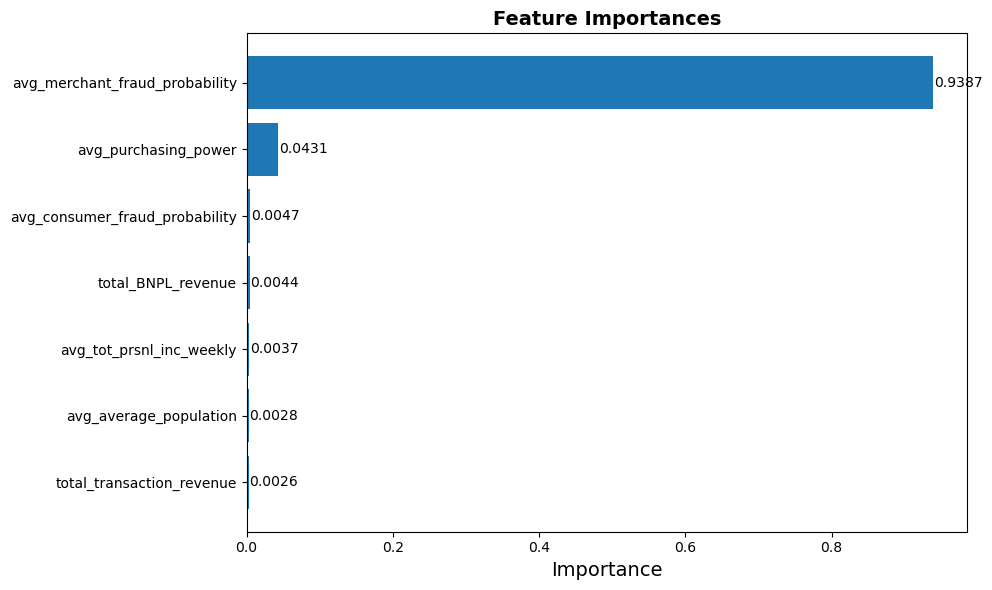

In [25]:
# Using the sorted_feature_importances_rf to create a dictionary
importance_dict = dict(sorted_feature_importances_rf)

# Sort the features and their importances from largest to smallest for the plot
sorted_features = sorted(importance_dict.items(), key=lambda x: x[1], reverse=False)

# Unpack the sorted features and importances
features_sorted = [x[0] for x in sorted_features]
importances_sorted = [x[1] for x in sorted_features]

# Create the plot
plt.figure(figsize=(10, 6))
bars = plt.barh(features_sorted, importances_sorted)
plt.xlabel('Importance', fontsize=14)
plt.title('Feature Importances', fontsize=14, fontweight="bold")

# Add labels to each bar
for bar in bars:
    plt.text(bar.get_width() + 0.001,  # Position the label slightly to the right of the bar
             bar.get_y() + bar.get_height()/2,  # Center the label vertically
             f'{bar.get_width():.4f}',  # Format the importance value
             va='center', fontsize=10)  # Align vertically at center and set font size

plt.tight_layout()

# save and display the plot
plt.savefig('../plots/ranking_feature_importances.png', dpi=300, bbox_inches='tight')
plt.show()

### Use Min-Max Scaling to rescale the feature values of above features in 0-100

In [26]:
all_features = [feature for feature, _ in sorted_feature_importances] + ["merchant_abn",
                                                                         "merchant_segment_1", 
                                                                         "merchant_segment_2", 
                                                                         "merchant_segment_3", 
                                                                         "merchant_segment_4",
                                                                         "merchant_segment_5"]
selected_transaction_by_merchant = aggregated_transaction_by_merchant.select(all_features)

In [27]:
# Extract feature names from sorted_feature_importances
feature_names = [feature for feature, _ in sorted_feature_importances]

# Calculate min and max values for the selected features
min_max_values = aggregated_transaction_by_merchant.select(
    *[F.min(col).alias(f'min_{col}') for col in feature_names],
    *[F.max(col).alias(f'max_{col}') for col in feature_names]
).collect()

# Extract the min and max for scaling
min_values = [min_max_values[0][f'min_{col}'] for col in feature_names]
max_values = [min_max_values[0][f'max_{col}'] for col in feature_names]

# Start with the original DataFrame
scaled_transaction_by_merchant = selected_transaction_by_merchant

# Perform scaling for each feature and create new columns with 'scaled_' prefix
for col, min_val, max_val in zip(feature_names, min_values, max_values):
    scaled_transaction_by_merchant = scaled_transaction_by_merchant.withColumn(
        f'scaled_{col}', ((F.col(col) - min_val) / (max_val - min_val) * 100)
    )

# Drop original columns
scaled_transaction_by_merchant = scaled_transaction_by_merchant.drop(*feature_names)

scaled_transaction_by_merchant.show(5)

+------------+-------------------------------------+---------------------------+-------------------------+----------------------+----------------------+-------------------------+----------------------+-------------------------+-------------------------+----------------------+-------------------------+-------------------------+-------------------------------------+-------------------+--------------------+-------------------+-------------------+-------------------+--------------------+---------------------------------+-------------------+--------------------+-----------------------------+----------------------+-------------------------+-------------------------------+--------------------------------+----------------------+-------------------------------+-------------------------+-------------------+----------------------+-----------------------------+-----------------------------+-------------------+----------------------+
|merchant_abn|scaled_avg_merchant_fraud_probability|scaled_avg_pu

Since higher `scaled_avg_merchant_fraud_probability` and `scaled_avg_consumer_fraud_probability` means more frequent fraudent behaviours (negative), we will change `scaled_avg_merchant_fraud_probability` and `scaled_avg_consumer_fraud_probability` to (100-`scaled_avg_merchant_fraud_probability`) and (100-`scaled_avg_consumer_fraud_probability`).

In [28]:
scaled_transaction_by_merchant = scaled_transaction_by_merchant \
    .withColumn('scaled_avg_merchant_fraud_probability', 100 - F.col('scaled_avg_merchant_fraud_probability')) \
    .withColumn('scaled_avg_consumer_fraud_probability', 100 - F.col('scaled_avg_consumer_fraud_probability')) 

scaled_transaction_by_merchant.describe().show()

+-------+--------------------+-------------------------------------+---------------------------+-------------------------+----------------------+----------------------+-------------------------+----------------------+-------------------------+-------------------------+----------------------+-------------------------+-------------------------+-------------------------------------+------------------+-----------------+------------------+------------------+------------------+------------------+---------------------------------+-----------------+--------------------+-----------------------------+----------------------+-------------------------+-------------------------------+--------------------------------+----------------------+-------------------------------+-------------------------+------------------+----------------------+-----------------------------+-----------------------------+------------------+----------------------+
|summary|        merchant_abn|scaled_avg_merchant_fraud_probab

### Check the shape of scaled dataset

In [29]:
num_rows = scaled_transaction_by_merchant.count()
print(f"Number of rows: {num_rows}")

num_columns = len(scaled_transaction_by_merchant.columns)
print(f"Number of columns: {num_columns}")

Number of rows: 4026
Number of columns: 37


# Compute the Ranking Score for Each Merchant

In [30]:
# Create a dictionary of feature importance for quick look-up
importance_dict = dict(sorted_feature_importances)

# Initialize the ranking score by multiplying each scaled feature by its respective importance
ranking_score_expr = reduce(
    lambda a, b: a + b, 
    [F.col(f'scaled_{col}') * F.lit(importance_dict[col]) for col, _ in sorted_feature_importances]
)

# Add a new column for the ranking score
ranked_transaction_by_merchant = scaled_transaction_by_merchant.withColumn('ranking_score', ranking_score_expr)

ranked_transaction_by_merchant.show(5)

+------------+-------------------------------------+---------------------------+-------------------------+----------------------+----------------------+-------------------------+----------------------+-------------------------+-------------------------+----------------------+-------------------------+-------------------------+-------------------------------------+-------------------+--------------------+-------------------+-------------------+-------------------+--------------------+---------------------------------+-------------------+--------------------+-----------------------------+----------------------+-------------------------+-------------------------------+--------------------------------+----------------------+-------------------------------+-------------------------+-------------------+----------------------+-----------------------------+-----------------------------+-------------------+----------------------+------------------+
|merchant_abn|scaled_avg_merchant_fraud_probab

# Overall Top 100 Merchants

### Select Overall Top 100 Merchants

In [31]:
# Rename columns
ranked_transaction_by_merchant = ranked_transaction_by_merchant \
    .withColumnRenamed('scaled_avg_merchant_fraud_probability', 'scaled_avg_merchant_not_fraud_probability') \
    .withColumnRenamed('scaled_avg_consumer_fraud_probability', 'scaled_avg_consumer_not_fraud_probability')

In [32]:
# Sort the DataFrame by 'ranking_score' in descending order
sorted_ranked_transaction_by_merchant = ranked_transaction_by_merchant.orderBy(F.col('ranking_score').desc())

# Select the top 100 rows
top_100_ranked_transactions = sorted_ranked_transaction_by_merchant.limit(100)
top_100_ranked_transactions.show(100)

+------------+-----------------------------------------+---------------------------+-------------------------+----------------------+----------------------+-------------------------+----------------------+-------------------------+-------------------------+----------------------+-------------------------+-------------------------+-----------------------------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+---------------------------------+--------------------+--------------------+-----------------------------+----------------------+-------------------------+-------------------------------+--------------------------------+----------------------+-------------------------------+-------------------------+-------------------+----------------------+-----------------------------+-----------------------------+-------------------+----------------------+-----------------+
|merchant_abn|scaled_avg_merchant_n

In [33]:
# Use the correct column names in the list for the select statement
non_zero_segment_counts = top_100_ranked_transactions.select(
    [
        F.sum(F.when(F.col(col_name) != 0, 1).otherwise(0)).alias(f'non_zero_{col_name}')
        for col_name in ['scaled_merchant_segment_1', 'scaled_merchant_segment_2', 
                         'scaled_merchant_segment_3', 'scaled_merchant_segment_4', 
                         'scaled_merchant_segment_5']
    ]
).collect()

# Extract the results into a dictionary for display
non_zero_segment_counts_dict = {f'non_zero_{col_name}': non_zero_segment_counts[0][f'non_zero_{col_name}'] for col_name in ['scaled_merchant_segment_1', 
                                                                                                                            'scaled_merchant_segment_2', 
                                                                                                                            'scaled_merchant_segment_3', 
                                                                                                                            'scaled_merchant_segment_4', 
                                                                                                                            'scaled_merchant_segment_5']}

# Map column names without the 'non_zero_' prefix to their human-readable names
segment_names = {
    'non_zero_scaled_merchant_segment_1': 'Personal Care and Repair Services',
    'non_zero_scaled_merchant_segment_2': 'Arts',
    'non_zero_scaled_merchant_segment_3': 'Home and Furniture',
    'non_zero_scaled_merchant_segment_4': 'Gifts and Souvenirs',
    'non_zero_scaled_merchant_segment_5': 'Technology and Electronic Equipment'
}

# Loop through and print the results with the correct segment names
for col_name, count in non_zero_segment_counts_dict.items():
    print(f"Number of merchants in Segment - {segment_names[col_name]}: {count}")

Number of merchants in Segment - Personal Care and Repair Services: 0
Number of merchants in Segment - Arts: 20
Number of merchants in Segment - Home and Furniture: 1
Number of merchants in Segment - Gifts and Souvenirs: 0
Number of merchants in Segment - Technology and Electronic Equipment: 79


### Plots Related to Top 100 Merchants

In [34]:
# Convert the PySpark DataFrame to a Pandas DataFrame and cast merchant_abn to string
df = top_100_ranked_transactions.select(
    F.col("merchant_abn").cast("string"),  # Convert merchant_abn to string for plotting
    "scaled_avg_merchant_not_fraud_probability", 
    "scaled_avg_consumer_not_fraud_probability", 
    "scaled_avg_tot_prsnl_inc_weekly"
).toPandas()

#### Scaled Merchant Non-Fraud Probability

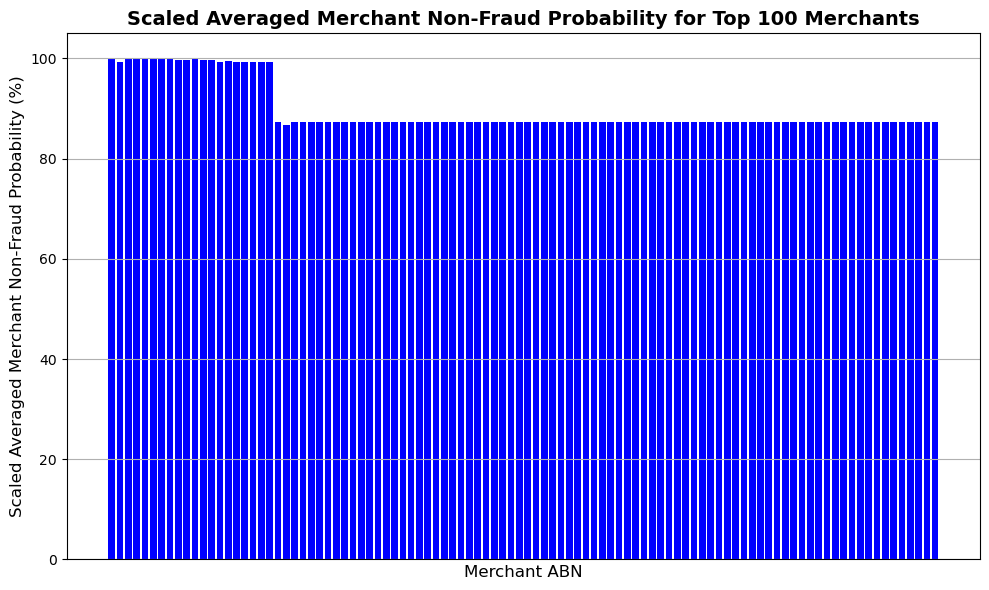

In [35]:
plt.figure(figsize=(10, 6))
plt.bar(df['merchant_abn'], df['scaled_avg_merchant_not_fraud_probability'], color='b')
plt.title("Scaled Averaged Merchant Non-Fraud Probability for Top 100 Merchants", fontsize=14, weight="bold")
plt.xlabel("Merchant ABN", fontsize=12)
plt.ylabel("Scaled Averaged Merchant Non-Fraud Probability (%)", fontsize=12)
plt.xticks([], [])  # Hide the x-axis tick labels but keep the x-axis label
plt.grid(True, axis='y')
plt.tight_layout()

# save and display the plot
plt.savefig('../plots/top100_merchant_non_fraud_prob.png', dpi=300, bbox_inches='tight')
plt.show()

#### Scaled Consumer Non-Fraud Probability

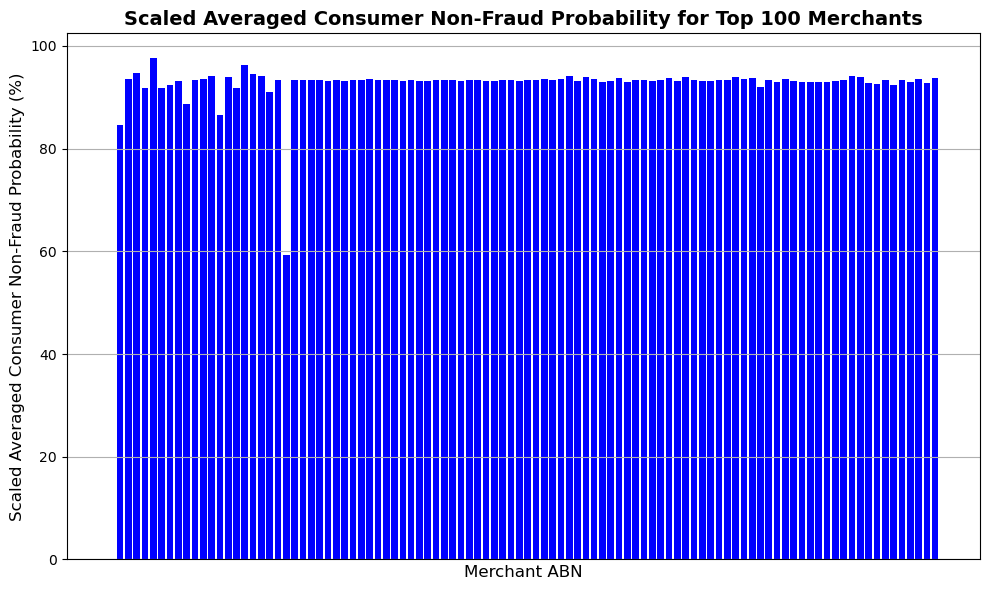

In [36]:
plt.figure(figsize=(10, 6))
plt.bar(df['merchant_abn'], df['scaled_avg_consumer_not_fraud_probability'], color='b')
plt.title("Scaled Averaged Consumer Non-Fraud Probability for Top 100 Merchants", fontsize=14, weight="bold")
plt.xlabel("Merchant ABN", fontsize=12)
plt.ylabel("Scaled Averaged Consumer Non-Fraud Probability (%)", fontsize=12)
plt.xticks([], [])  # Hide the x-axis tick labels but keep the x-axis label
plt.grid(True, axis='y')
plt.tight_layout()

# save and display the plot
plt.savefig('../plots/top100_consumer_non_fraud_prob.png', dpi=300, bbox_inches='tight')
plt.show()

#### Scaled Averaged Total Weekly Personal Income

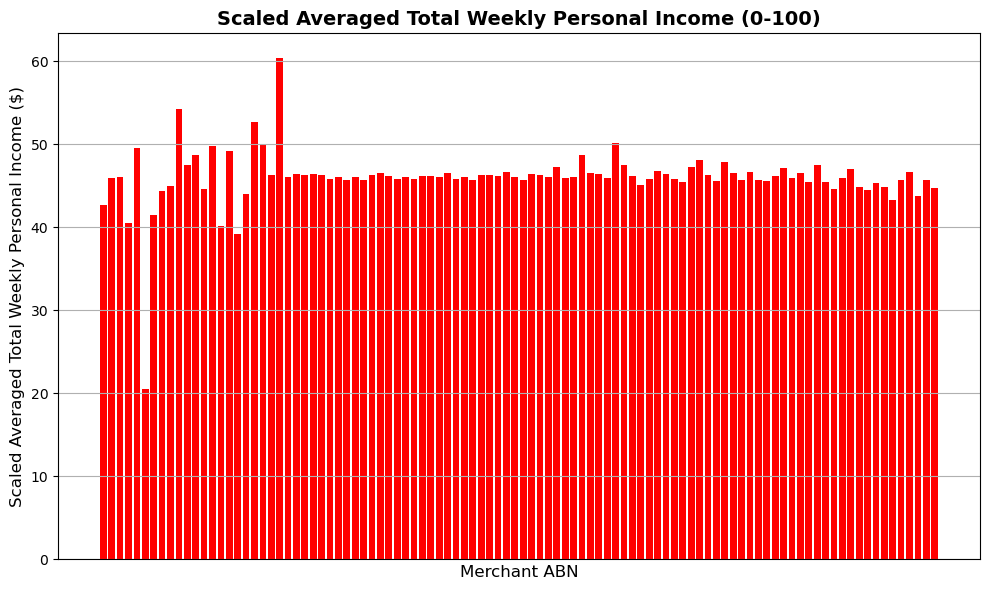

In [37]:
plt.figure(figsize=(10, 6))
plt.bar(df['merchant_abn'], df['scaled_avg_tot_prsnl_inc_weekly'], color='r')
plt.title("Scaled Averaged Total Weekly Personal Income (0-100)", fontsize=14, weight="bold")
plt.xlabel("Merchant ABN", fontsize=12)
plt.ylabel("Scaled Averaged Total Weekly Personal Income ($)", fontsize=12)
plt.xticks([], [])  # Hide the x-axis tick labels but keep the x-axis label
plt.grid(True, axis='y')
plt.tight_layout()

# save and display the plot
plt.savefig('../plots/top100_avg_tot_prsnl_income.png', dpi=300, bbox_inches='tight')
plt.show()

# Top 10 Merchants for Each Merchant Segment

### Select Top 10 Merchants for Each Merchant Segment

In [38]:
# Initialize an empty DataFrame to hold the combined top 10 merchants from all segments
combined_top_10_merchants = None

# Define the merchant segments and their corresponding names
segment_names = {
    'scaled_merchant_segment_1': 'Personal Care and Repair Services',
    'scaled_merchant_segment_2': 'Arts',
    'scaled_merchant_segment_3': 'Home and Furniture',
    'scaled_merchant_segment_4': 'Gifts and Souvenirs',
    'scaled_merchant_segment_5': 'Technology and Electronic Equipment'
}

# Loop through each segment and combine the top 10 merchants into one DataFrame
for segment, segment_name in segment_names.items():
    # Filter the merchants that belong to the current segment and sort by ranking_score (descending order), then limit to top 10
    top_10_segment = ranked_transaction_by_merchant.filter(F.col(segment) != 0).orderBy(F.col("ranking_score").desc()).limit(10)
    
    # Print the number of merchants in the current segment
    merchant_count = top_10_segment.count()
    print(f"Number of merchants in Segment - {segment_name}: {merchant_count}")
    top_10_segment.show(truncate=False)
    
    # Add a new column to indicate the segment name
    top_10_segment = top_10_segment.withColumn("segment_name", F.lit(segment_name))
    
    # If combined_top_10_merchants is empty, set it to top_10_segment, else union the current top_10_segment
    if combined_top_10_merchants is None:
        combined_top_10_merchants = top_10_segment
    else:
        combined_top_10_merchants = combined_top_10_merchants.union(top_10_segment)

# Show the combined DataFrame of top 10 merchants from all segments
combined_top_10_merchants.show(truncate=False)

Number of merchants in Segment - Personal Care and Repair Services: 10


+------------+-----------------------------------------+---------------------------+-------------------------+----------------------+----------------------+-------------------------+----------------------+-------------------------+-------------------------+----------------------+-------------------------+-------------------------+-----------------------------------------+------------------+------------------+------------------+------------------+------------------+------------------+---------------------------------+------------------+--------------------+-----------------------------+----------------------+-------------------------+-------------------------------+--------------------------------+----------------------+-------------------------------+-------------------------+------------------+----------------------+-----------------------------+-----------------------------+------------------+----------------------+-----------------+
|merchant_abn|scaled_avg_merchant_not_fraud_probab

Number of merchants in Segment - Arts: 10


+------------+-----------------------------------------+---------------------------+-------------------------+----------------------+----------------------+-------------------------+----------------------+-------------------------+-------------------------+----------------------+-------------------------+-------------------------+-----------------------------------------+---------------------+--------------------+-------------------+--------------------+---------------------+------------------+---------------------------------+--------------------+---------------------+-----------------------------+----------------------+-------------------------+-------------------------------+--------------------------------+----------------------+-------------------------------+-------------------------+-------------------+----------------------+-----------------------------+-----------------------------+-------------------+----------------------+-----------------+
|merchant_abn|scaled_avg_merchant_

Number of merchants in Segment - Home and Furniture: 10


+------------+-----------------------------------------+---------------------------+-------------------------+----------------------+----------------------+-------------------------+----------------------+-------------------------+-------------------------+----------------------+-------------------------+-------------------------+-----------------------------------------+--------------------+--------------------+--------------------+--------------------+---------------------+--------------------+---------------------------------+--------------------+---------------------+-----------------------------+----------------------+-------------------------+-------------------------------+--------------------------------+----------------------+-------------------------------+-------------------------+-------------------+----------------------+-----------------------------+-----------------------------+-------------------+----------------------+-----------------+
|merchant_abn|scaled_avg_merchan

Number of merchants in Segment - Gifts and Souvenirs: 10


+------------+-----------------------------------------+---------------------------+-------------------------+----------------------+----------------------+-------------------------+----------------------+-------------------------+-------------------------+----------------------+-------------------------+-------------------------+-----------------------------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+---------------------------------+--------------------+--------------------+-----------------------------+----------------------+-------------------------+-------------------------------+--------------------------------+----------------------+-------------------------------+-------------------------+-------------------+----------------------+-----------------------------+-----------------------------+-------------------+----------------------+-----------------+
|merchant_abn|scaled_avg_merchant_n

Number of merchants in Segment - Technology and Electronic Equipment: 10


+------------+-----------------------------------------+---------------------------+-------------------------+----------------------+----------------------+-------------------------+----------------------+-------------------------+-------------------------+----------------------+-------------------------+-------------------------+-----------------------------------------+------------------+------------------+------------------+------------------+------------------+------------------+---------------------------------+------------------+--------------------+-----------------------------+----------------------+-------------------------+-------------------------------+--------------------------------+----------------------+-------------------------------+-------------------------+------------------+----------------------+-----------------------------+-----------------------------+------------------+----------------------+-----------------+
|merchant_abn|scaled_avg_merchant_not_fraud_probab

+------------+-----------------------------------------+---------------------------+-------------------------+----------------------+----------------------+-------------------------+----------------------+-------------------------+-------------------------+----------------------+-------------------------+-------------------------+-----------------------------------------+---------------------+--------------------+-------------------+--------------------+---------------------+------------------+---------------------------------+--------------------+---------------------+-----------------------------+----------------------+-------------------------+-------------------------------+--------------------------------+----------------------+-------------------------------+-------------------------+-------------------+----------------------+-----------------------------+-----------------------------+-------------------+----------------------+-----------------+---------------------------------+


### Plots Related to Top 10 Merchants for Segment 5 - Technology and Electronic Equipment 

In [39]:
# Filter merchants where scaled_merchant_segment_1 = 100.0 (Personal Care and Repair Services)
filtered_merchants = combined_top_10_merchants[combined_top_10_merchants['scaled_merchant_segment_5'] == 100.0]

# Convert the filtered PySpark DataFrame to Pandas DataFrame
filtered_merchants_pd = filtered_merchants.toPandas()

#### Scaled Merchant Non-Fraud Probability

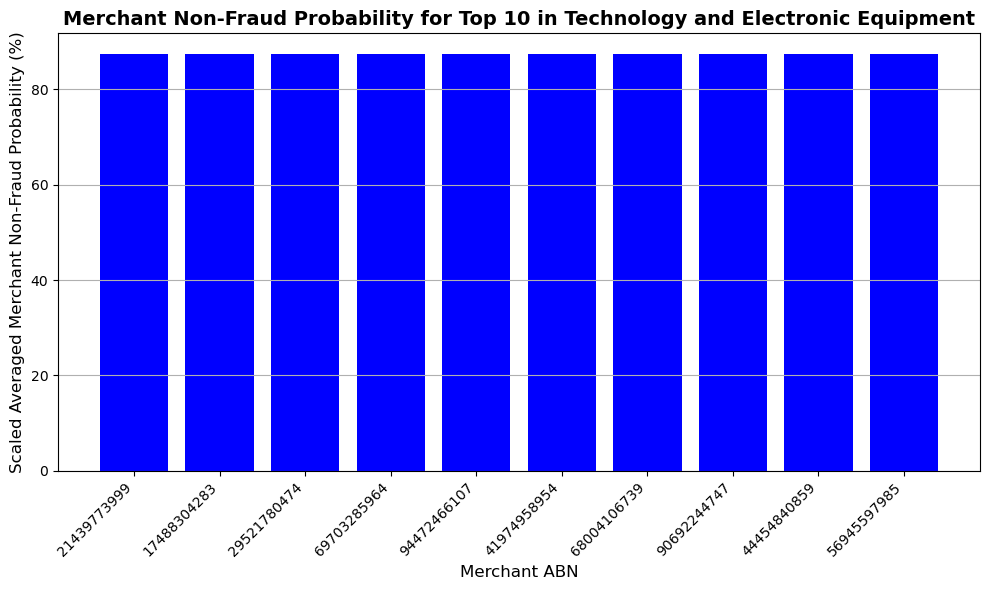

In [40]:
# Convert the 'merchant_abn' column to string to prevent scientific notation
filtered_merchants_pd['merchant_abn'] = filtered_merchants_pd['merchant_abn'].astype(str)

# Plot 1: Scaled Averaged Merchant Non-Fraud Probability
plt.figure(figsize=(10, 6))
plt.bar(filtered_merchants_pd['merchant_abn'], 
        filtered_merchants_pd['scaled_avg_merchant_not_fraud_probability'], color='b')
plt.title("Merchant Non-Fraud Probability for Top 10 in Technology and Electronic Equipment", 
          fontsize=14, weight="bold")
plt.xlabel("Merchant ABN", fontsize=12)
plt.ylabel("Scaled Averaged Merchant Non-Fraud Probability (%)", fontsize=12)
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability
plt.grid(True, axis='y')
plt.tight_layout()

# Save and display the plot
plt.savefig('../plots/top10_merchant_non_fraud_prob_seg5.png', dpi=300, bbox_inches='tight')
plt.show()

#### Scaled Consumer Non-Fraud Probability

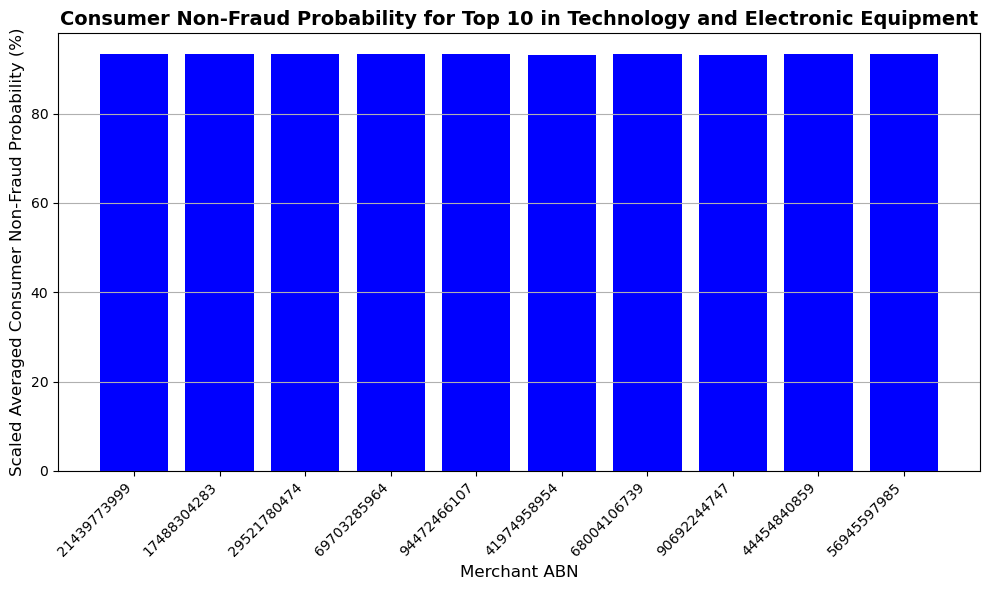

In [41]:
# Convert the 'merchant_abn' column to string to prevent scientific notation
filtered_merchants_pd['merchant_abn'] = filtered_merchants_pd['merchant_abn'].astype(str)

# Plot 1: Scaled Averaged Merchant Non-Fraud Probability
plt.figure(figsize=(10, 6))
plt.bar(filtered_merchants_pd['merchant_abn'], 
        filtered_merchants_pd['scaled_avg_consumer_not_fraud_probability'], color='b')
plt.title("Consumer Non-Fraud Probability for Top 10 in Technology and Electronic Equipment", 
          fontsize=14, weight="bold")
plt.xlabel("Merchant ABN", fontsize=12)
plt.ylabel("Scaled Averaged Consumer Non-Fraud Probability (%)", fontsize=12)
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability
plt.grid(True, axis='y')
plt.tight_layout()

# Save and display the plot
plt.savefig('../plots/top10_consumer_non_fraud_prob_seg5.png', dpi=300, bbox_inches='tight')
plt.show()

#### Scaled Averaged Total Weekly Personal Income

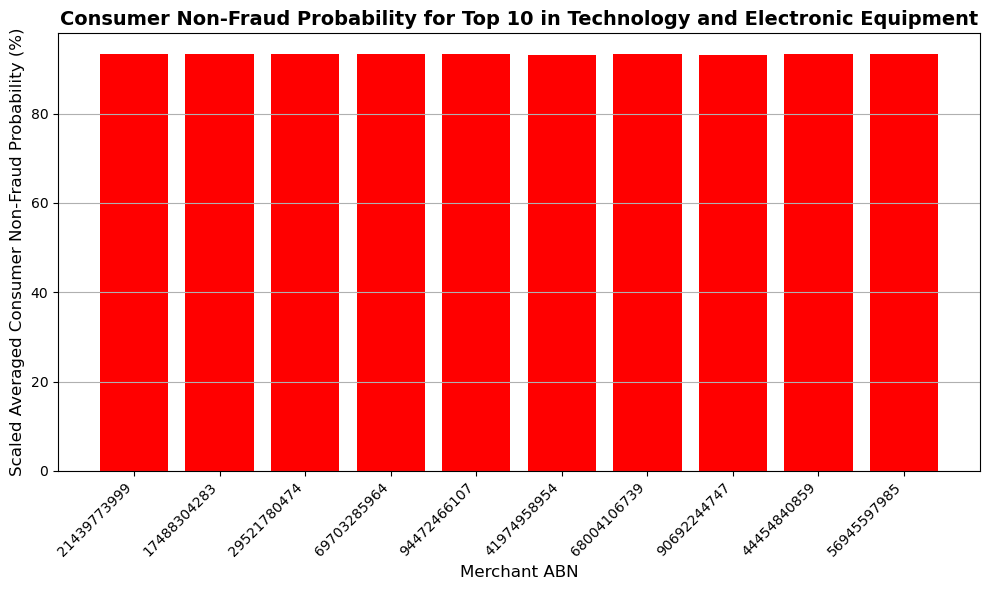

In [42]:
# Convert the 'merchant_abn' column to string to prevent scientific notation
filtered_merchants_pd['merchant_abn'] = filtered_merchants_pd['merchant_abn'].astype(str)

# Plot 1: Scaled Averaged Merchant Non-Fraud Probability
plt.figure(figsize=(10, 6))
plt.bar(filtered_merchants_pd['merchant_abn'], 
        filtered_merchants_pd['scaled_avg_consumer_not_fraud_probability'], color='r')
plt.title("Consumer Non-Fraud Probability for Top 10 in Technology and Electronic Equipment", 
          fontsize=14, weight="bold")
plt.xlabel("Merchant ABN", fontsize=12)
plt.ylabel("Scaled Averaged Consumer Non-Fraud Probability (%)", fontsize=12)
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability
plt.grid(True, axis='y')
plt.tight_layout()

# Save and display the plot
plt.savefig('../plots/top10_avg_tot_prsnl_income_seg5.png', dpi=300, bbox_inches='tight')
plt.show()